In [24]:
# General imports
import numpy as np
import qiskit
# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [17]:
# [Reference]: https://docs.quantum.ibm.com/guides/build-noise-models
# https://docs.quantum.ibm.com/guides/simulate-with-qiskit-aer

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.noise import (
    NoiseModel,QuantumError,ReadoutError,depolarizing_error,pauli_error,thermal_relaxation_error,
)
# YOUR_API_TOKEN = "a44932650c6324c729fbd156e2808cff2dc96cc78fdaf3058a5e3583edfadad4acf73471140788f0efa7ed71a98f1e13069af52fe115e4e0e2bb868ab0be5d70"
# QiskitRuntimeService.save_account(channel="ibm_quantum", token= YOUR_API_TOKEN, overwrite = True)
# service = QiskitRuntimeService()
# backend = service.backend("ibm_brisbane")
# noise_model = NoiseModel.from_backend(backend)

# Code for Shadow Tomography of Quantum States

In [26]:
# Here we will write the necessary codes for shadow tomography.

def Minv(N_qubits,X):
    return ((2**N_qubits+1.))*X - np.eye(2**N_qubits)

def shadow_tomography_clifford(N_qubits,quantum_circuit, reps = 1):

    cliffords = [qiskit.quantum_info.random_clifford(N_qubits,) for _ in range(n_Shadows)]
    
    rho_actual = qiskit.quantum_info.DensityMatrix(quantum_circuit).data
    
    results = []
    for cliff in cliffords:
        qc_c  = quantum_circuit.compose(cliff.to_circuit())

        counts = qiskit.quantum_info.Statevector(qc_c).sample_counts(reps)
        results.append(counts)
        
    shadows = []
    for cliff, res in zip(cliffords, results):
        mat    = cliff.adjoint().to_matrix()
        for bit,count in res.items():
            Ub = mat[:,int(bit,2)] # this is Udag|b>
            shadows.append(Minv(N_qubits,np.outer(Ub,Ub.conj()))*count)

    #rho_shadow = np.sum(shadows,axis=0)/(nShadows*reps)

    return rho_actual,shadows


def linear_function_prediction(N,K,operator_linear,list_of_shadows):
    list_of_means = []
    
    # calculating K means
    for k in range(1,K+1):
        shadows_mean = 0.0
        for j in range(N*(k-1)+1,N*k+1):
            rho_j = list_of_shadows[j-1]
            shadows_mean += np.trace(operator_linear@rho_j )
            
        list_of_means.append(shadows_mean/N)
        
    # calculating the median of K means
    return np.median(list_of_means)

def quadratic_function_prediction(N,K,operator_m,operator_n,list_of_shadows):
    
    list_of_means = []
    
    SWAP = np.matrix([[1,0,0,0],
                      [0,0,1,0],
                      [0,1,0,0],
                      [0,0,0,1]])
    r"""
    
    calculating the operator O. Note that the order of operator_m and operator_n is irrelevant.
    
    """
    
    O_quadratic = SWAP@np.kron(operator_m,operator_n)
    
    # calculating K means
    for k in range(1,K+1):
        shadows_mean = 0.0        
        for j in range(N*(k-1)+1,N*k+1):
            for l in range(N*(k-1)+1,N*k+1):
                if j != l:
                    rho_j = list_of_shadows[j-1]
                    rho_l = list_of_shadows[l-1]
                    shadows_mean += np.trace(O_quadratic@np.kron(rho_j,rho_l))
                    
        list_of_means.append(shadows_mean/(N*(N-1)))
        
    # calculating their median
    return np.median(list_of_means)    

In [19]:
# Example error probabilities
p_reset = 0.05
p_meas = 0.2
p_gate1 = 0.1
 
# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)
 
# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])
 
noise_model = noise_bit_flip
print(noise_bit_flip)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u3', 'u2', 'u1', 'reset', 'measure', 'cx']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


In [20]:
# VQA circuit.
from qiskit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer.primitives import EstimatorV2 as Estimator

def vqa_circuit(theta_x, theta_y, theta_z, phi):
     vqa_circuit = QuantumCircuit(2)
     vqa_circuit.rx(theta_x, 0)
     vqa_circuit.ry(theta_y, 0)
     vqa_circuit.rz(theta_z, 0)
     vqa_circuit.cry(phi, 0, 1)
     return vqa_circuit

# Cost function f(rho) = x_rho^2 + y_rho^2 + z_rho^2 where x_rho, y_rho, z_rho are the expectation values of the Pauli operators X, Y, Z

# Measuring x_rho, y_rho, z_rho
def run_vqa_circuit_estimator(theta_x, theta_y, theta_z, phi):

     ansatz_circuit = vqa_circuit(theta_x, theta_y, theta_z, phi)
     
     x_rho_mean_lst = []
     x_rho_std_lst = []

     y_rho_mean_lst = []
     y_rho_std_lst = []

     z_rho_mean_lst = []
     z_rho_std_lst = []

     pauli_observable_x = SparsePauliOp.from_list([("IX", 1.0)])
     pauli_observable_y = SparsePauliOp.from_list([("IY", 1.0)])
     pauli_observable_z = SparsePauliOp.from_list([("IZ", 1.0)])

     #estimator = Estimator(mode=real_backend_simulator)
     estimator = Estimator(options=dict(backend_options=dict(noise_model=noise_model)))
     pm = generate_preset_pass_manager(3, AerSimulator())
     isa_psi = pm.run(ansatz_circuit)

     # X
     isa_observables = pauli_observable_x.apply_layout(isa_psi.layout)
     job = estimator.run([(isa_psi, isa_observables)])
     pub_result = job.result()[0]
     x_rho_mean_lst.append(pub_result.data.evs)
     x_rho_std_lst.append(pub_result.data.stds)   

     # Y
     isa_observables = pauli_observable_y.apply_layout(isa_psi.layout)
     job = estimator.run([(isa_psi, isa_observables)])
     pub_result = job.result()[0]
     y_rho_mean_lst.append(pub_result.data.evs)
     y_rho_std_lst.append(pub_result.data.stds)

     # Z
     isa_observables = pauli_observable_z.apply_layout(isa_psi.layout)
     job = estimator.run([(isa_psi, isa_observables)])
     pub_result = job.result()[0]
     z_rho_mean_lst.append(pub_result.data.evs)
     z_rho_std_lst.append(pub_result.data.stds)

     return x_rho_mean_lst, x_rho_std_lst, y_rho_mean_lst, y_rho_std_lst, z_rho_mean_lst, z_rho_std_lst

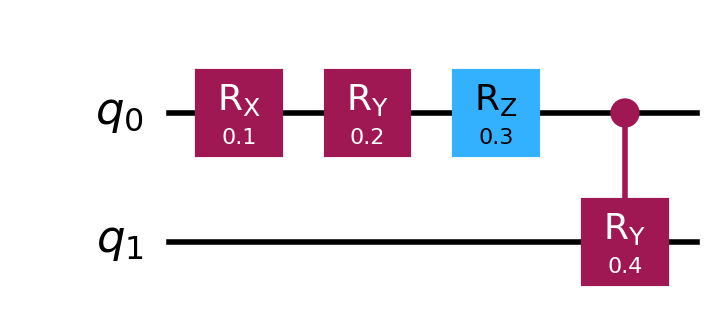

In [21]:
# Drawing the circuit for visualization.
vqa_circuit(0.1, 0.2, 0.3, 0.4).draw("mpl", scale=2)

In [27]:
# Shadow tomography.
N = 40
K = 10
n_Shadows = N*K
st_instance = shadow_tomography_clifford(2, vqa_circuit(0.1, 0.2, 0.3, 0.4))

In [29]:
# Expectation values of the linear functions.
linear_function_prediction(N, K, SparsePauliOp.from_list([("IX", 1.0)]).to_matrix(), st_instance[1])

(-4.4408920985006264e-17+0j)

In [10]:
from qiskit import transpile
trans_qc = transpile(vqa_circuit(0.1, 0.2, 0.3, 0.4), basis_gates = ["id", "rx", "ry", "rz", "cx"])
trans_qc.draw("mpl", scale = 2).savefig("vqa_circuit.pdf", dpi = 600)

In [2]:
# def cost_function(theta_x, theta_y, theta_z, phi):
#      x_rho_mean_lst, x_rho_std_lst, y_rho_mean_lst, y_rho_std_lst, z_rho_mean_lst, z_rho_std_lst = run_vqa_circuit_estimator(theta_x, theta_y, theta_z, phi)
#      return x_rho_mean_lst[0]**2 + y_rho_mean_lst[0]**2 + z_rho_mean_lst[0]**2

def cost_function(b, gamma_1, gamma_2, rho):

     # Coefficients in the cost function.
     f00 = b**2/2 + 5*gamma_1**2/8 + gamma_1*gamma_2 + 2*gamma_2**2
     f02 = - b*gamma_1
     f03 = -gamma_1**2
     f11 = -b**2/2
     f33 = 3*gamma_1**2/8 - gamma_1*gamma_2 - 2*gamma_2**2
     f23 = b*gamma_1/2 - 2*gamma_2*b

     # Cost function.
     return f00*np.trace(rho@rho) + f02*np.trace(sigma_y@rho@rho) + f03*np.trace(sigma_z@rho@rho) + f11*np.trace(sigma_x@rho@sigma_x@rho) + f33*np.trace(sigma_z@rho@sigma_z@rho) + f23*np.trace(sigma_y@rho@sigma_z@rho)

# Cost function landscape plot

In [ ]:
# x = np.linspace(0, 2*np.pi, 30)
# y = np.linspace(0, 2*np.pi, 30)
# X, Y = np.meshgrid(x, y)
   
# Z = np.array([[cost_function(p, 0, q, np.pi) for p in x] for q in y])

In [ ]:
# # matplotlib parameters 
# large = 40; med = 20; small = 20
# params = {'axes.titlesize': med,'axes.titlepad' : med,
#                       'legend.fontsize': med,'axes.labelsize': med ,
#                       'axes.titlesize': med ,'xtick.labelsize': med ,
#                       'ytick.labelsize': med ,'figure.titlesize': med}
# plt.rcParams["font.family"] = "Helvetica"
# plt.rcParams["font.serif"] = ["Helvetica Neue"]          
# #plt.rcParams['text.usetex'] = True # need LaTeX. Change it to False if LaTeX is not installed in the system
# plt.rcParams.update(params)

# fig = plt.figure(figsize=(15, 10))
# ax = plt.axes(projection="3d")
# colorscheme = "viridis"
# ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=colorscheme, edgecolor="k", linewidth=1)
# ax.set_title("Plot of Cost Function", pad=10)
# ax.set_xlabel("p", labelpad=20)
# ax.set_ylabel("q", labelpad=20)
# ax.set_zlabel("Cost function", labelpad=20)  # Add z-axis label
# cbar = plt.colorbar(ax.plot_surface(X, Y, Z, cmap=colorscheme), label="Cost function", shrink=0.5, aspect=5, pad=0.05)
# cbar.set_label("Cost function", labelpad=20)  # Adjust labelpad to move the label further from the colorbar
# ax.view_init(elev=30, azim=40)  # You can change elev and azim to desired values
# plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)
# plt.show()

# Parameter shift rule and variation

In [ ]:
tolerance_for_convergence = 1.e-2
theta_x = np.random.uniform(-np.pi, np.pi)
theta_y = np.random.uniform(-np.pi, np.pi)
theta_z = np.random.uniform(-np.pi, np.pi)
phi = np.random.uniform(-np.pi, np.pi)

print("Initial set of parameters =", theta_x, theta_y, theta_z, phi)

initial_learning_rate = 2.0
number_of_iterations = 0
max_iterations = 100

best_cost = float("inf")
best_theta_x, best_theta_y, best_theta_z, best_phi = theta_x, theta_y, theta_z, phi
best_iteration = 0

while number_of_iterations < max_iterations:

    cost_value = cost_function(theta_x, theta_y, theta_z, phi)

    # Update best parameters if a new minimum cost is found
    if cost_value < best_cost:
        best_cost = cost_value
        best_theta_x, best_theta_y, best_theta_z, best_phi = theta_x, theta_y, theta_z, phi
        best_iteration = number_of_iterations  # Update iteration number for best cost    

    if cost_value <= tolerance_for_convergence:
        print("\n[CONVERGED] Cost function is less than the tolerance value.\n")
        print("Cost function =", cost_value)
        print("Optimized parameters =", theta_x, theta_y, theta_z, phi)
        break

    # Decaying learning rate
    learning_rate = initial_learning_rate / np.sqrt(number_of_iterations + 1)

    # Parameter shift rule for gradient calculation
    gradient_theta_x = 0.5 * (cost_function(theta_x + np.pi / 2, theta_y, theta_z, phi) - cost_function(theta_x - np.pi / 2, theta_y, theta_z, phi))
    gradient_theta_y = 0.5 * (cost_function(theta_x, theta_y + np.pi / 2, theta_z, phi) - cost_function(theta_x, theta_y - np.pi / 2, theta_z, phi))
    gradient_theta_z = 0.5 * (cost_function(theta_x, theta_y, theta_z + np.pi / 2, phi) - cost_function(theta_x, theta_y, theta_z - np.pi / 2, phi))
    gradient_phi = 0.5 * (cost_function(theta_x, theta_y, theta_z, phi + np.pi / 2) - cost_function(theta_x, theta_y, theta_z, phi - np.pi / 2))

    # Parameter update
    theta_x -= learning_rate * gradient_theta_x
    theta_y -= learning_rate * gradient_theta_y
    theta_z -= learning_rate * gradient_theta_z
    phi -= learning_rate * gradient_phi

    number_of_iterations += 1
    print("Cost function =", cost_value)
    print("Number of iterations =", number_of_iterations)
    print("Learning rate =", learning_rate)

if number_of_iterations == max_iterations:
    print("\n[STOPPED] Maximum number of iterations reached.\n")
    print("Cost function =", cost_function(theta_x, theta_y, theta_z, phi))
    print("Optimized parameters =", theta_x, theta_y, theta_z, phi)
    print("\n[RESULT] Minimum cost encountered =", best_cost)
    print("Parameters corresponding to minimum cost =", best_theta_x, best_theta_y, best_theta_z, best_phi)
    print("Iteration number for minimum cost =", best_iteration)

In [ ]:
import numpy as np

# Initialization of tolerance, parameters, and learning rate
tolerance_for_convergence = 1.e-2
theta_x, theta_y, theta_z, phi = [np.random.uniform(0, 2 * np.pi) for _ in range(4)]
print("Initial parameters =", theta_x, theta_y, theta_z, phi)

initial_learning_rate = 1.0
number_of_iterations = 0
max_iterations = 100
beta1, beta2, epsilon = 0.9, 0.999, 1e-8
m, v = [0]*4, [0]*4
max_gradient = 1.0  # Gradient clipping threshold

# Track the best parameters and the corresponding iteration number
best_cost = float("inf")
best_theta_x, best_theta_y, best_theta_z, best_phi = theta_x, theta_y, theta_z, phi
best_iteration = 0

while number_of_iterations < max_iterations:
    cost_value = cost_function(theta_x, theta_y, theta_z, phi)
    
    # Update best parameters if a new minimum cost is found
    if cost_value < best_cost:
        best_cost = cost_value
        best_theta_x, best_theta_y, best_theta_z, best_phi = theta_x, theta_y, theta_z, phi
        best_iteration = number_of_iterations  # Update iteration number for best cost
    
    # Check for convergence
    if cost_value <= tolerance_for_convergence:
        print("\n[CONVERGED] Cost function =", cost_value)
        print("Optimized parameters =", theta_x, theta_y, theta_z, phi)
        print("Convergence reached at iteration =", number_of_iterations)
        break
    
    # Decaying learning rate for Adam
    learning_rate = initial_learning_rate / np.sqrt(number_of_iterations + 1)
    
    # Calculate gradients using parameter shift
    gradients = [
        0.5 * (cost_function(theta_x + np.pi/2, theta_y, theta_z, phi) - cost_function(theta_x - np.pi/2, theta_y, theta_z, phi)),
        0.5 * (cost_function(theta_x, theta_y + np.pi/2, theta_z, phi) - cost_function(theta_x, theta_y - np.pi/2, theta_z, phi)),
        0.5 * (cost_function(theta_x, theta_y, theta_z + np.pi/2, phi) - cost_function(theta_x, theta_y, theta_z - np.pi/2, phi)),
        0.5 * (cost_function(theta_x, theta_y, theta_z, phi + np.pi/2) - cost_function(theta_x, theta_y, theta_z, phi - np.pi/2))
    ]
    
    # Adam update with gradient clipping
    for i, grad in enumerate(gradients):
        grad = np.clip(grad, -max_gradient, max_gradient)  # Clipping
        m[i] = beta1 * m[i] + (1 - beta1) * grad
        v[i] = beta2 * v[i] + (1 - beta2) * (grad ** 2)
        m_hat = m[i] / (1 - beta1 ** (number_of_iterations + 1))
        v_hat = v[i] / (1 - beta2 ** (number_of_iterations + 1))
        
        if i == 0:
            theta_x -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
        elif i == 1:
            theta_y -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
        elif i == 2:
            theta_z -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
        elif i == 3:
            phi -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
    
    number_of_iterations += 1
    print(f"Iteration {number_of_iterations}: Cost =", cost_value)

# After the loop, print the best found values and corresponding iteration number
print("\n[RESULT] Minimum cost encountered =", best_cost)
print("Parameters corresponding to minimum cost =", best_theta_x, best_theta_y, best_theta_z, best_phi)
print("Iteration number for minimum cost =", best_iteration)